In [1]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
    dataset = load_dataset("scene_parse_150")

In [2]:

from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [3]:
from transformers import SegformerFeatureExtractor

root_dir = './custom_dataset'
feature_extractor = SegformerFeatureExtractor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, train=False)

/opt/conda/lib/python3.7/site-packages/transformers/models/segformer/feature_extraction_segformer.py:31: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/models/segformer/image_processing_segformer.py:105: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  FutureWarning,


In [4]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 180
Number of validation examples: 20


In [5]:
encoded_inputs = train_dataset[0]

In [6]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [7]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [8]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   0,   0,   0],
        [255, 255, 255,  ...,   0,   0,   0],
        [255, 255, 255,  ...,   0,   0,   0],
        ...,
        [  6,   6,   6,  ...,   6,   6,   6],
        [  6,   6,   6,  ...,   6,   6,   6],
        [  6,   6,   6,  ...,   6,   6,   6]])

In [9]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   1,   3,   4,   5,   6, 255])

In [10]:

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [11]:
batch = next(iter(train_dataloader))

In [12]:

for k,v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [13]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [14]:
mask = (batch["labels"] != 255)
mask

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [15]:

batch["labels"][mask]

tensor([0, 0, 0,  ..., 6, 6, 6])

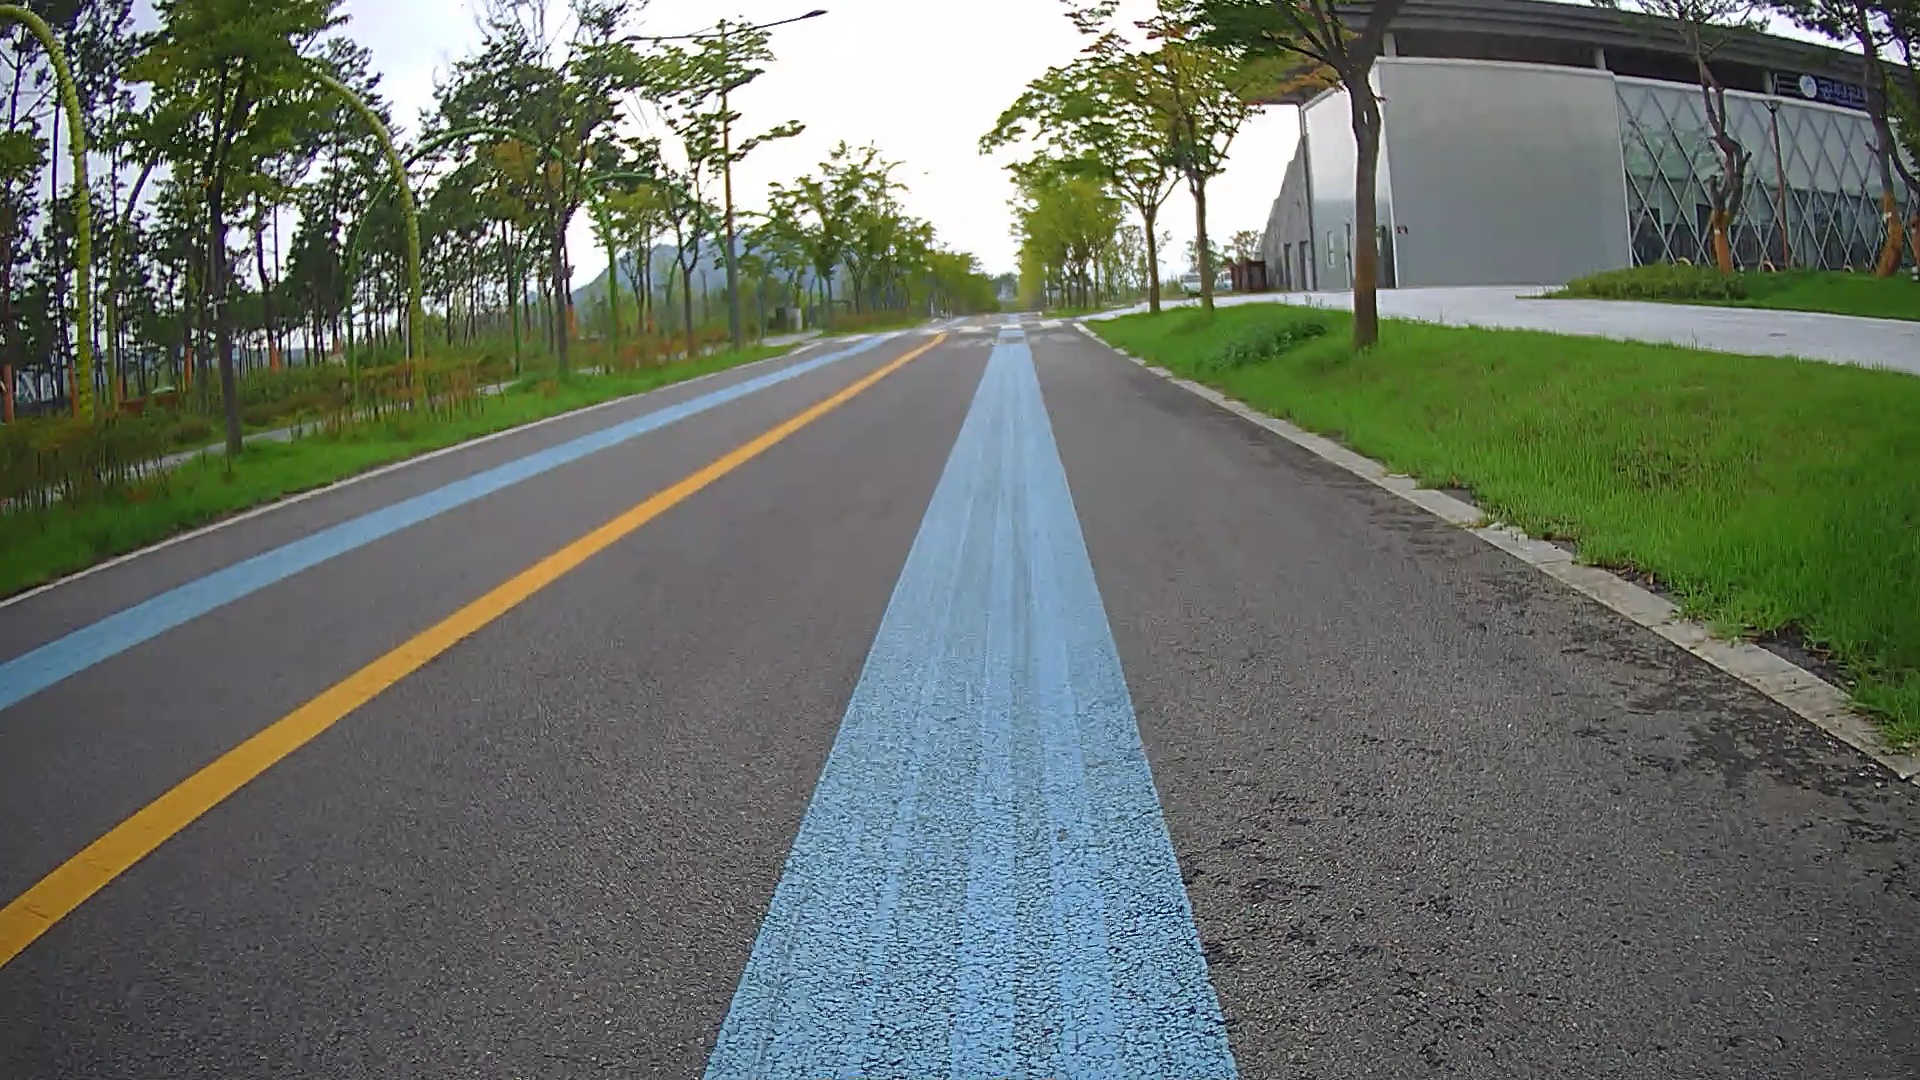

In [16]:
image = Image.open('./custom_dataset/images/training/SC_PAR_20220831_155720_cam01.jpg')
# image = Image.open('./ADE20k_toy_dataset/images/training/ADE_train_00000009.jpg') 
image

In [17]:
# def ade_palette():
#     """ADE20K palette that maps each class to RGB values."""
#     return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
#             [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
#             [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
#             [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
#             [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
#             [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
#             [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
#             [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
#             [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
#             [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
#             [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
#             [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
#             [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
#             [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
#             [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
#             [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
#             [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
#             [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
#             [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
#             [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
#             [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
#             [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
#             [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
#             [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
#             [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
#             [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
#             [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
#             [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
#             [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
#             [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
#             [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
#             [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
#             [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
#             [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
#             [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
#             [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
#             [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
#             [102, 255, 0], [92, 0, 255]]

def ade_palette():
    return [[204, 5, 255], [4, 250, 7], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 10, 255], [255, 5, 153], [180, 120, 120],
            [150, 5, 61], [220, 220, 220], [255, 245, 0], [0, 102, 200]]

In [18]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

# load id2label mapping from a JSON on the hub

filename = "./custom_dataset/label_json.json"
with open (filename, "r") as f:
    id2label = json.load(f)
    
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
print(label2id)
# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=12, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

{'obstacle': 0, 'vegetation': 1, 'void': 2, 'truck': 3, 'building': 4, 'sidewalk': 5, 'crosswalk': 6, 'road': 7, 'pedestrian': 8, 'stone': 9, 'bicycle': 10, 'vehicle': 11}


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.bias', 'decode_

In [19]:


from datasets import load_metric

metric = load_metric("mean_iou")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
# import torch
# from torch import nn
# from sklearn.metrics import accuracy_score
# from tqdm.notebook import tqdm

# # define optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# # move model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model.to(device)

# model.train()
# for epoch in range(3):  # loop over the dataset multiple times
#     print("Epoch:", epoch)
#     for idx, batch in enumerate(tqdm(train_dataloader)):
#         # get the inputs;
#         pixel_values = batch["pixel_values"].to(device)
#         labels = batch["labels"].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(pixel_values=pixel_values, labels=labels)
#         loss, logits = outputs.loss, outputs.logits
        
#         loss.backward()
#         optimizer.step()

#         # evaluate
#         with torch.no_grad():
#             upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
#             predicted = upsampled_logits.argmax(dim=1)
          
#             # note that the metric expects predictions + labels as numpy arrays
#             metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

#         # let's print loss and metrics every 100 batches
#         if idx % 100 == 0:
#             metrics = metric._compute(num_labels=len(id2label),ignore_index=255, reduce_labels=False
#                                       ,predictions=predicted.detach().cpu().numpy()
#                                       ,references=labels.detach().cpu().numpy())

#             print("Loss:", loss.item())
#             print("Mean_iou:", metrics["mean_iou"])
#             print("Mean accuracy:", metrics["mean_accuracy"])
#         torch.save(model, f"./convertor/check_point/model_{epoch}.pth")

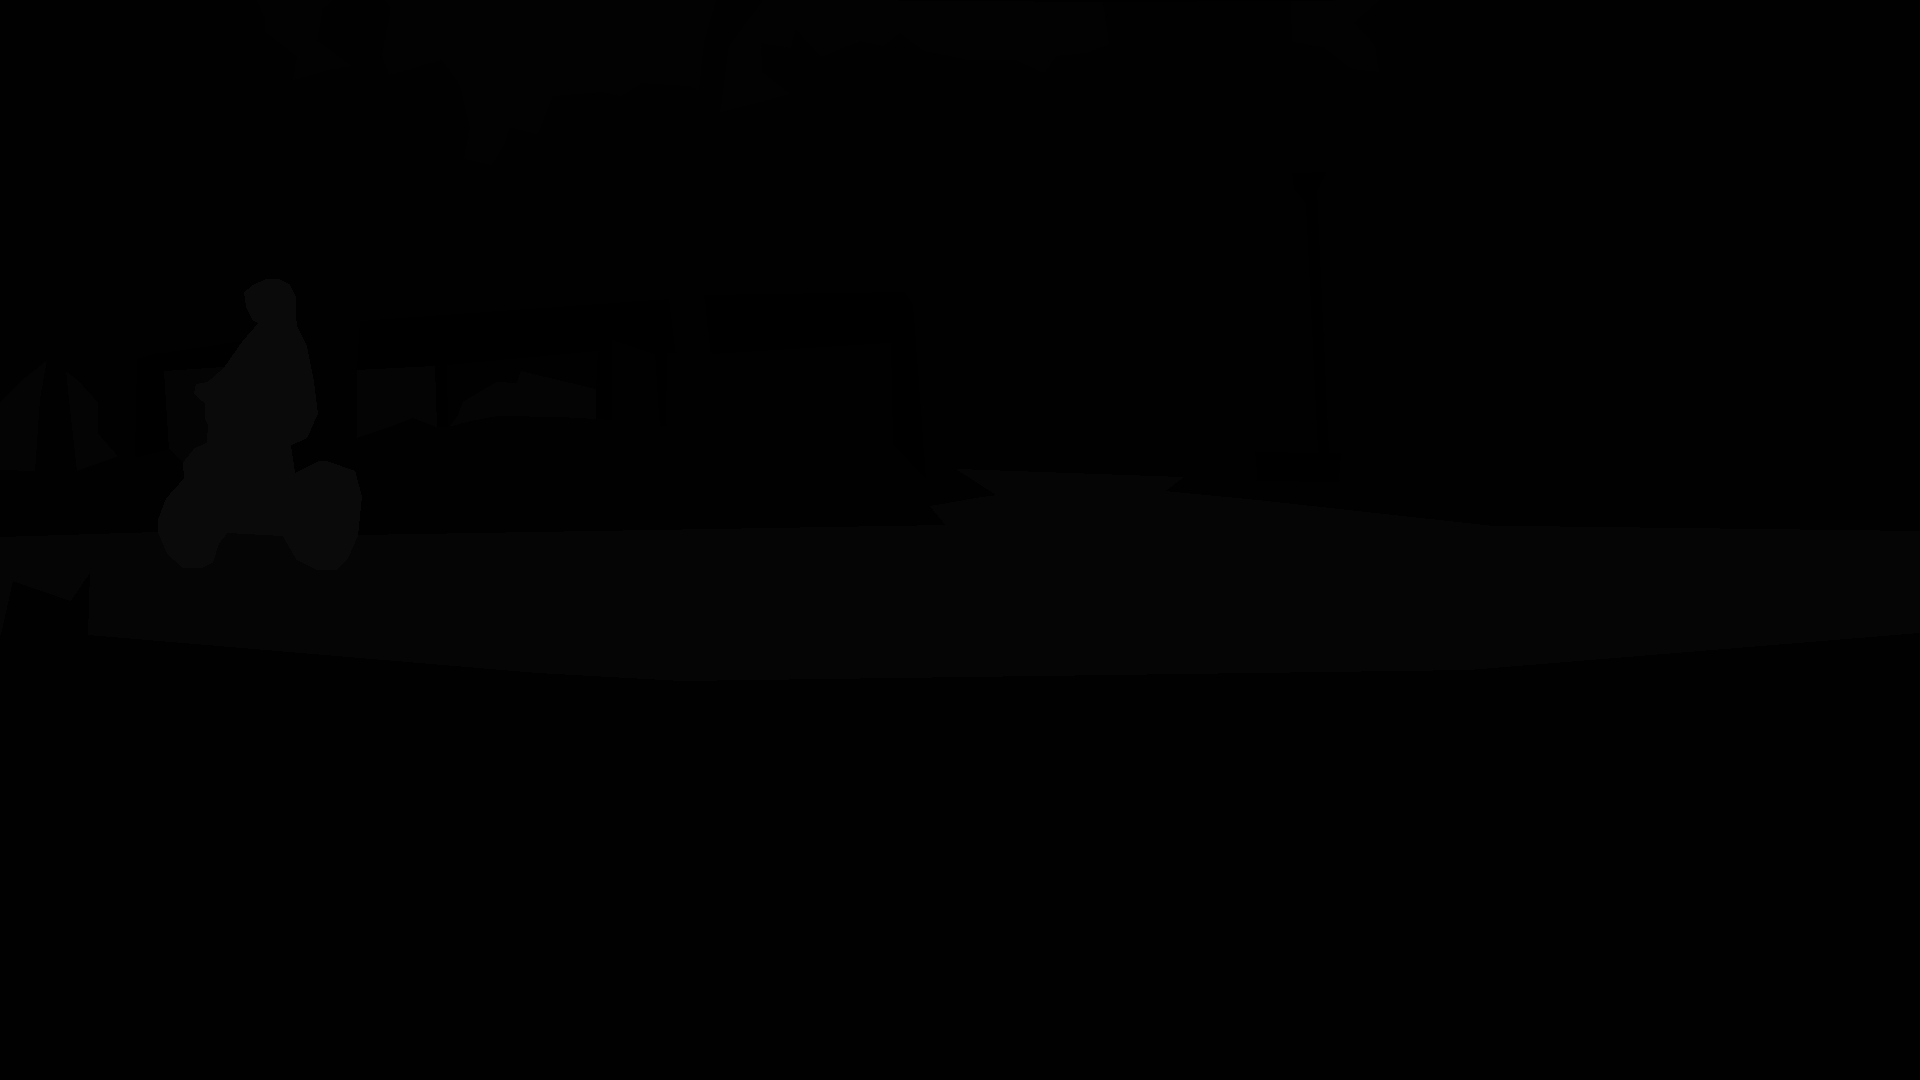

In [28]:
map = Image.open('./custom_dataset/annotations/training/SC_PAR_20220831_155720_cam02.png') 
# map = Image.open('./ADE20k_toy_dataset/annotations/training/ADE_train_00000009.png') 
map 

map (1080, 1920)
color_seg [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
label 0
color [204   5 255]


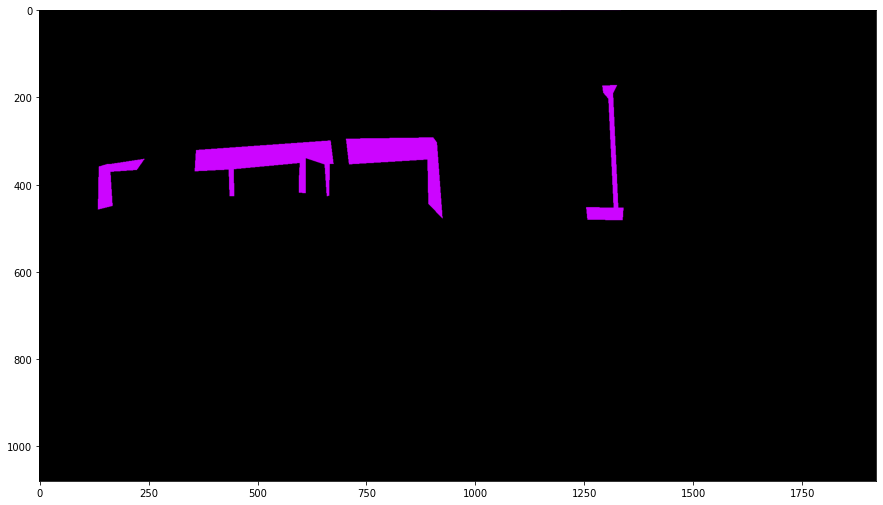

label 1
color [  4 250   7]


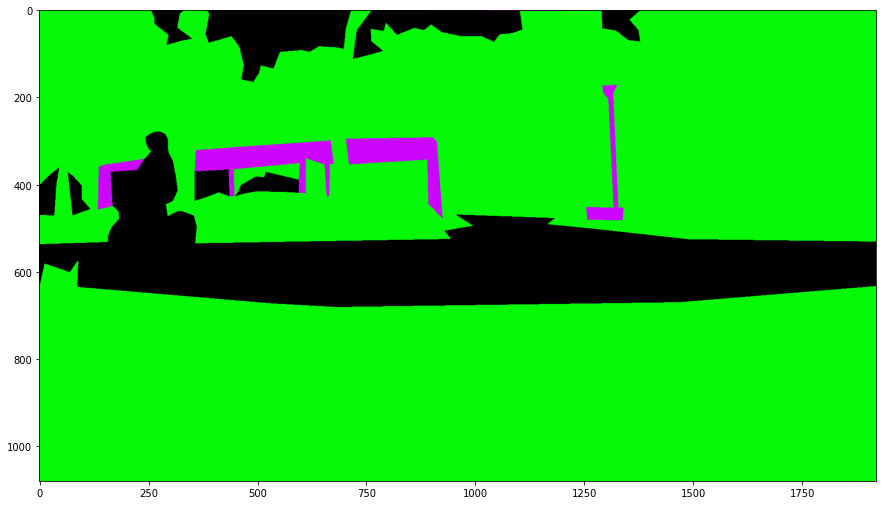

label 2
color [255 173   0]


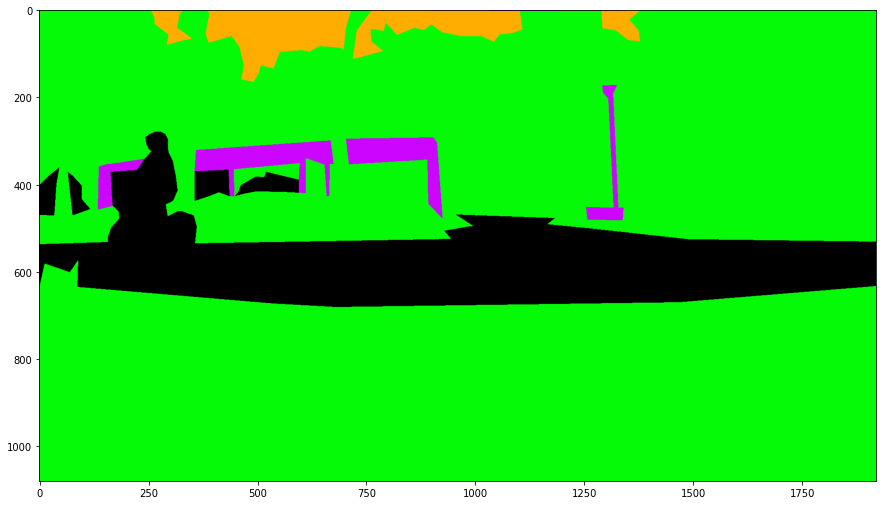

label 3
color [255   0  20]


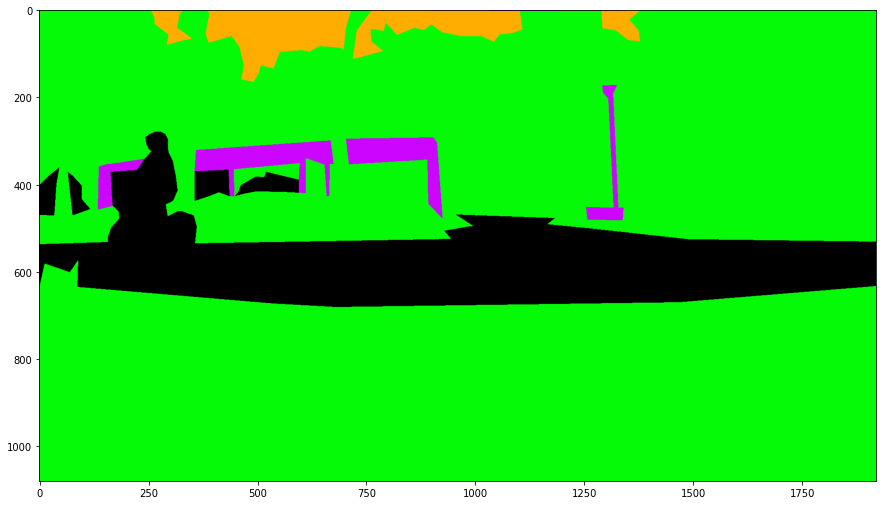

label 4
color [255 184 184]


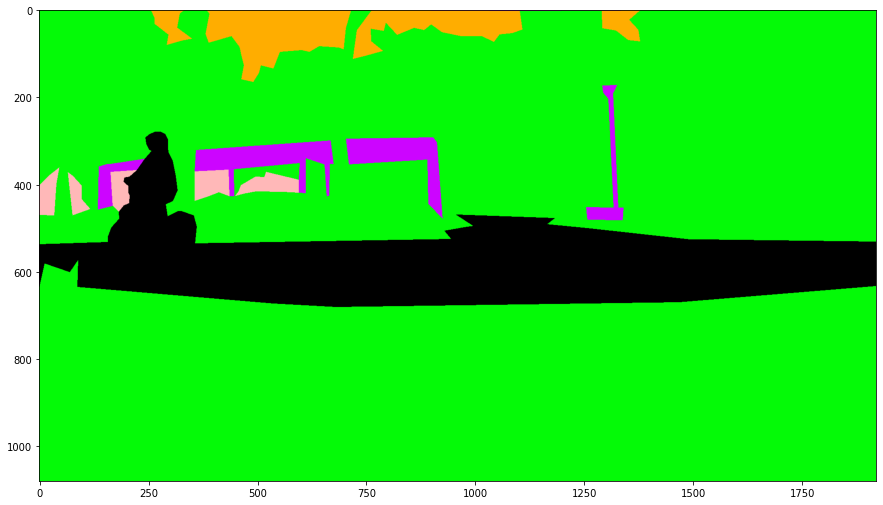

label 5
color [  0  10 255]


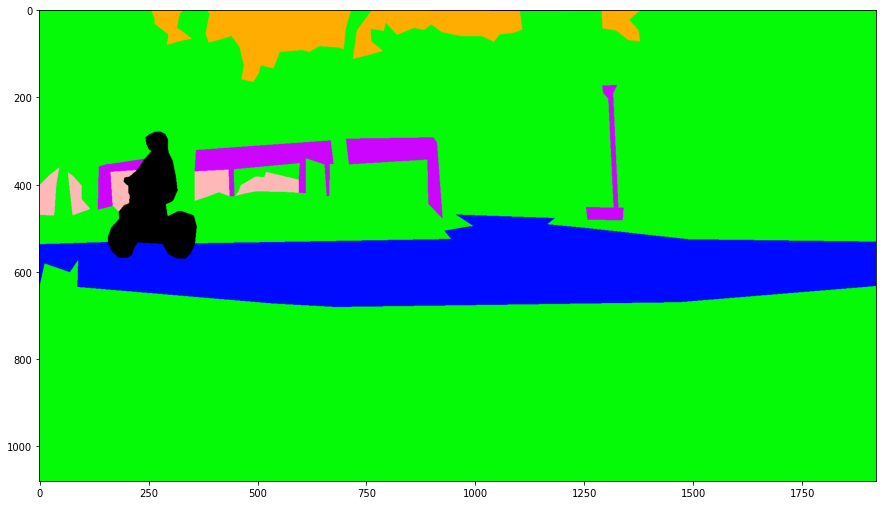

label 6
color [255   5 153]


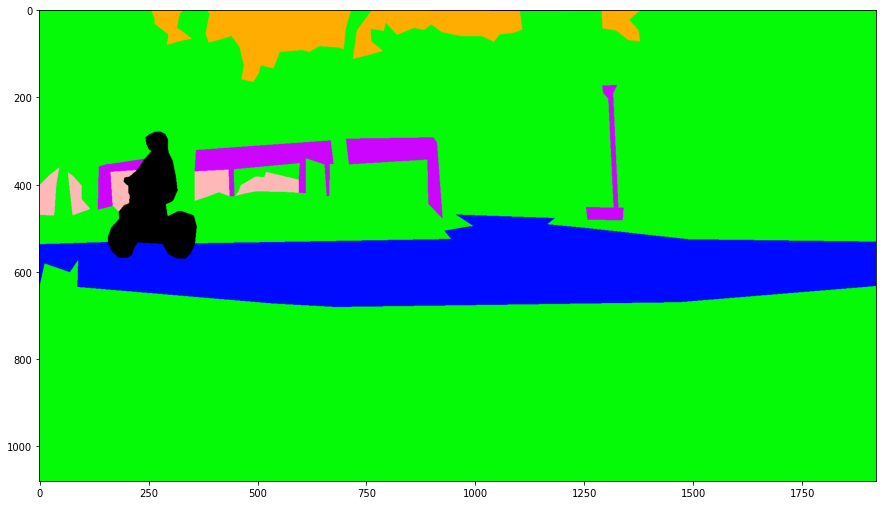

label 7
color [180 120 120]


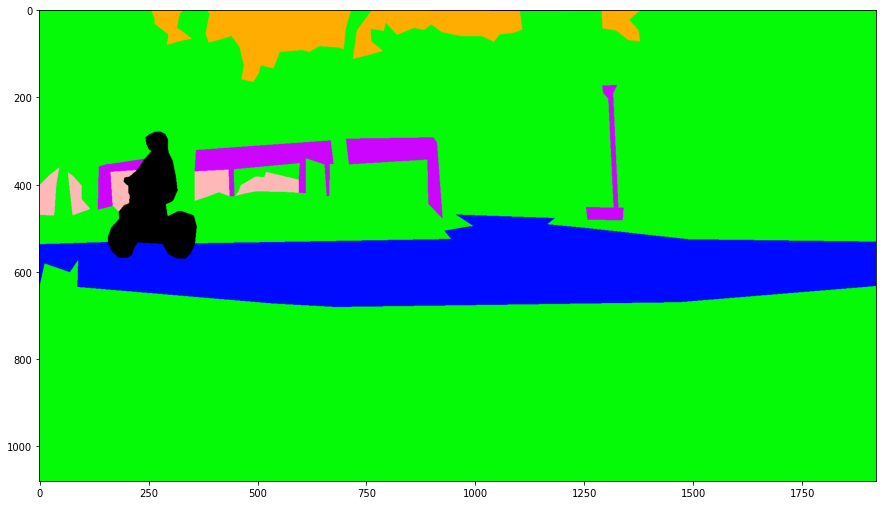

label 8
color [150   5  61]


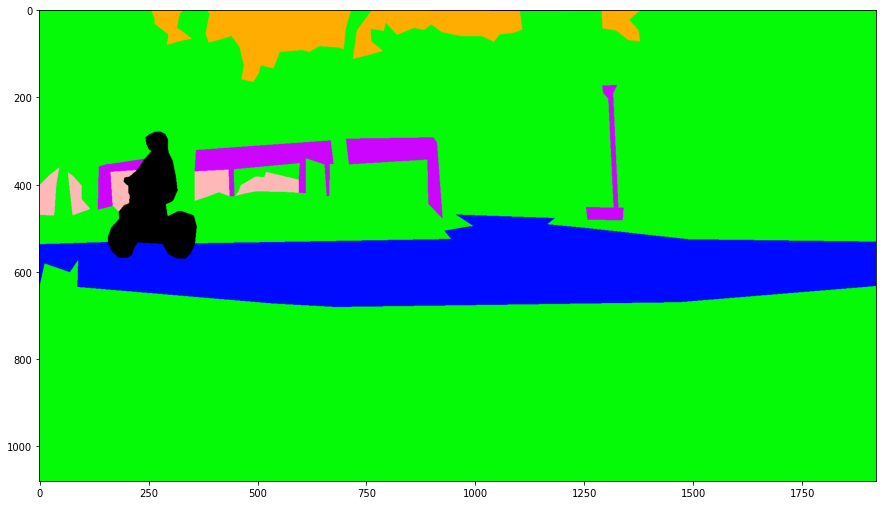

label 9
color [220 220 220]


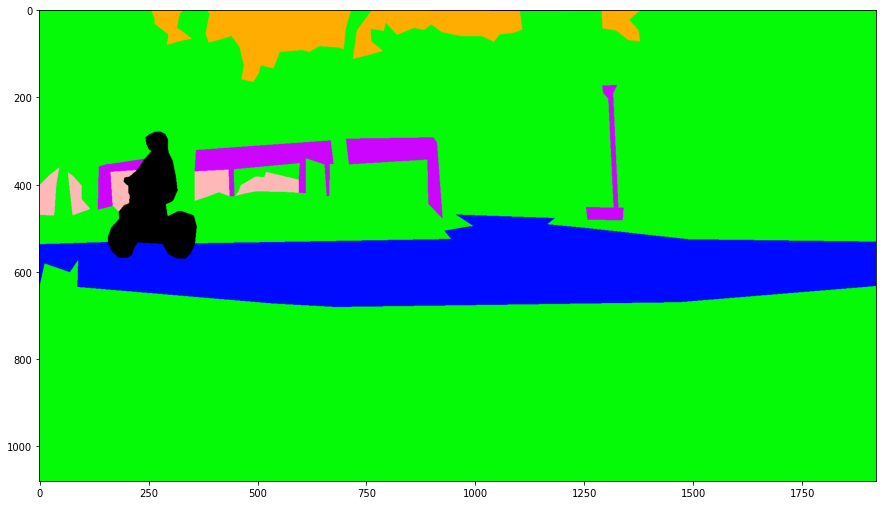

label 10
color [255 245   0]


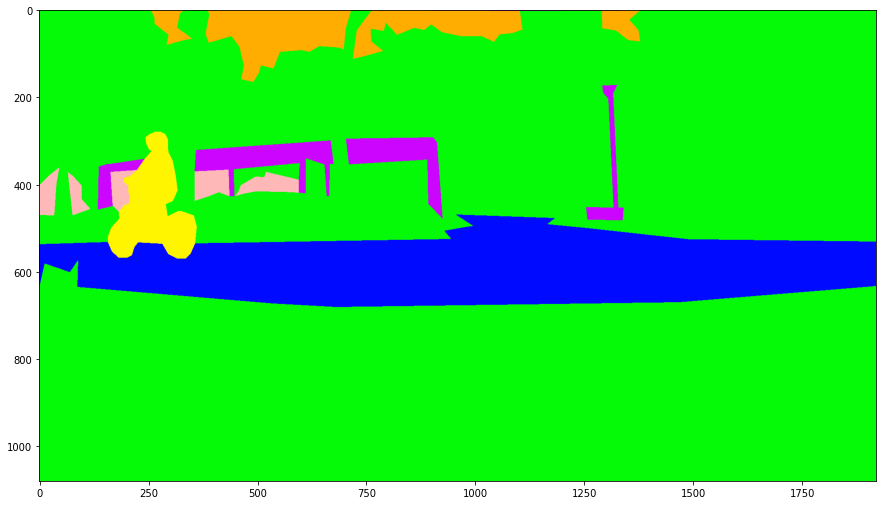

label 11
color [  0 102 200]


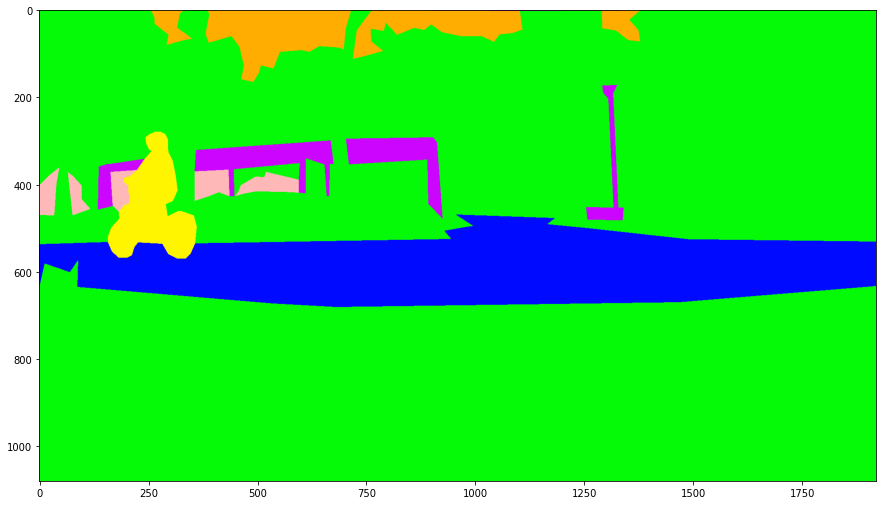

In [29]:
# convert map to NumPy array
import numpy as np
import matplotlib.pyplot as plt
import cv2
map = np.array(map)
print(f'map {map.shape}')
# map[map == 0] = 255 # background class is replaced by ignore_index
# map = map - 1 # other classes are reduced by one
# map[map == 254] = 255

# classes_map = np.unique(map).tolist()
# unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
# print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
print('color_seg',color_seg)
for label, color in enumerate(palette):
    
    color_seg[map == label, :] = color
    
    
    print('label',label)
    print('color',color)
    plt.figure(figsize=(15, 10))
    plt.imshow(color_seg)
    plt.show()

# label_list = {"0": "obstacle" , #보라색
#      "1": "vegetation",  #연두색
#      "2": "void", #주황
#      "3": "truck", #빨강
#      "4": "building", #분홍
#      "5": "sidewalk", #파랑
#      "6": "crosswalk", # 핫핑크
#      "7": "road", # 갈색
#      "8": "pedestrian", #카키색
#      "9": "stone", #회색
#      "10": "bicycle", #노란색
#      "11": "vehicle"} #네이비
# # Convert to BGR

# color_seg = color_seg[..., ::-1]


# # cv2.imwrite('test.jpg',color_seg)
# # # Show image + mask
# img = np.array(image) * 0.5 + color_seg * 0.5
# img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(color_seg)
# plt.show()

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.show()

In [24]:
import cv2

im = cv2.imread('./custom_dataset/annotations/training/SC_PAR_20220831_155720_cam02.png')
im

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)